In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
np.random.seed(1337)  # for reproducibility

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import CSVLogger

In [ ]:
# from tensorflow.keras.utils import get_file
# try:
#     pathTrain = get_file('Train.csv', origin=\
#     'https://github.com/N19DCCN058/KDD/raw/main/'\
#     'Train.csv',archive_format=None)
#     pathTest = get_file('Test.csv', origin=\
#     'http://github.com/N19DCCN058/KDD/raw/main/'\
#     'Test.csv',archive_format=None)
# except:
#     print('Error downloading')
#     raise
# traindata = pd.read_csv(pathTrain)
# testdata = pd.read_csv(pathTest)

traindata = pd.read_csv('Train.csv')
testdata = pd.read_csv('Test.csv')
print(traindata)
print(testdata)

In [ ]:
encoder = LabelEncoder()
for name in traindata.columns:
  if name in ['protocol_type','service','flag']:
    traindata[name] = encoder.fit_transform(traindata[name])
    testdata[name] = encoder.fit_transform(testdata[name])

In [ ]:
traindata

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,1,49,5,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,2,49,9,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,1,54,9,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,1,30,5,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


#0=Normal, 1=DoS, 2=Probe, 3=R2L, 4=U2R

In [ ]:

labeldf=traindata['class']
labeldf_test=testdata['class']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



# put the new label column back
traindata['class'] = newlabeldf
testdata['class'] = newlabeldf_test

In [ ]:
traindata
print(traindata['class'].value_counts())

0    67343
1    45927
2    11656
3      995
4       52
Name: class, dtype: int64


In [ ]:
testdata

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,45,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
1,0,1,45,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1
2,2,1,19,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0
3,0,0,13,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,2
4,1,1,55,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
22540,0,1,22,9,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
22542,0,2,11,9,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


#X là lấy 41 cột đầu tiên của file traindata
#Y là lấy cột cuối cùng của file traindata
#C là lấy 41 cột đầu tiên của file testdata
#T là lấy cột cuối cùng của file testdata

In [ ]:
X = traindata.iloc[0:75000,0:41]
Y = traindata.iloc[0:75000,41]
C = testdata.iloc[:,41]
T = testdata.iloc[:,0:41]

                          Specs         Score
4                     src_bytes  2.276451e+10
5                     dst_bytes  1.444883e+10
0                      duration  8.773565e+07
22                        count  4.714407e+06
32           dst_host_srv_count  4.174536e+06
31               dst_host_count  9.215591e+05
9                           hot  1.892365e+05
23                    srv_count  1.075861e+05
2                       service  5.455666e+04
3                          flag  3.470577e+04
38     dst_host_srv_serror_rate  3.362738e+04
25              srv_serror_rate  3.290981e+04
24                  serror_rate  3.264170e+04
37         dst_host_serror_rate  3.256414e+04
11                    logged_in  2.281882e+04
15                     num_root  2.148669e+04
12              num_compromised  1.824554e+04
33       dst_host_same_srv_rate  1.513539e+04
28                same_srv_rate  1.504687e+04
35  dst_host_same_src_port_rate  1.486298e+04
34       dst_host_diff_srv_rate  9

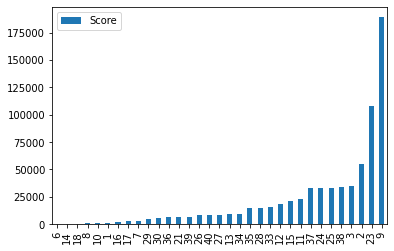

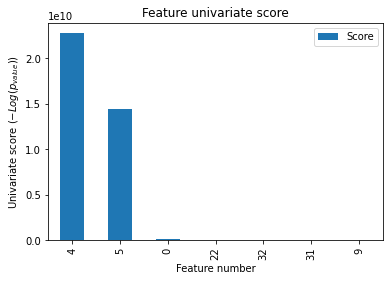

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
bestfeatures = SelectKBest(score_func=chi2, k=18)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs', 'Score']
featureScores = featureScores.dropna()
featureScores.sort_values(by='Score', ascending=False)
print(featureScores.nlargest(41,'Score'))
featureScores.nsmallest(33,'Score').plot(kind='bar')
featureScores.nlargest(7,'Score').plot(kind='bar')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [ ]:
# scaler = Normalizer().fit(X)
# trainX = scaler.transform(X)
trainX = fit.transform(X)
trainX

array([[0.0e+00, 2.0e+01, 9.0e+00, ..., 1.7e-01, 0.0e+00, 0.0e+00],
       [0.0e+00, 4.4e+01, 9.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 4.9e+01, 5.0e+00, ..., 1.0e-01, 1.0e+00, 1.0e+00],
       ...,
       [5.0e+00, 5.4e+01, 9.0e+00, ..., 5.7e-01, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.8e+01, 5.0e+00, ..., 1.5e-01, 1.0e+00, 1.0e+00],
       [0.0e+00, 5.4e+01, 5.0e+00, ..., 3.7e-01, 1.0e-02, 1.0e-02]])

In [ ]:
# scaler = Normalizer().fit(T)
# testT = scaler.transform(T)
testT = fit.transform(T)
testT

array([[0.0e+00, 4.5e+01, 1.0e+00, ..., 4.0e-02, 0.0e+00, 0.0e+00],
       [0.0e+00, 4.5e+01, 1.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [2.0e+00, 1.9e+01, 9.0e+00, ..., 6.1e-01, 0.0e+00, 0.0e+00],
       ...,
       [0.0e+00, 2.2e+01, 9.0e+00, ..., 1.0e+00, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.1e+01, 9.0e+00, ..., 9.9e-01, 0.0e+00, 0.0e+00],
       [0.0e+00, 5.2e+01, 1.0e+00, ..., 8.0e-02, 0.0e+00, 0.0e+00]])

In [ ]:
Y

0        0
1        0
2        1
3        0
4        0
        ..
74995    0
74996    0
74997    0
74998    1
74999    0
Name: class, Length: 75000, dtype: int64

In [ ]:
y_train1 = np.array(Y)
y_train1

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
y_test1 = np.array(C)
y_test1

array([1, 1, 0, ..., 1, 0, 2])

In [ ]:
y_train= to_categorical(y_train1)
y_test = to_categorical(y_test1)

In [ ]:
y_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

# reshape input to be [samples, time steps, features]

In [ ]:
X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_train
print(trainX.shape)
print(trainX.shape[0], trainX.shape[1])
print(X_train.shape)

(75000, 18)
75000 18
(75000, 1, 18)


In [ ]:
X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))
X_test

array([[[0.0e+00, 4.5e+01, 1.0e+00, ..., 4.0e-02, 0.0e+00, 0.0e+00]],

       [[0.0e+00, 4.5e+01, 1.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00]],

       [[2.0e+00, 1.9e+01, 9.0e+00, ..., 6.1e-01, 0.0e+00, 0.0e+00]],

       ...,

       [[0.0e+00, 2.2e+01, 9.0e+00, ..., 1.0e+00, 0.0e+00, 0.0e+00]],

       [[0.0e+00, 1.1e+01, 9.0e+00, ..., 9.9e-01, 0.0e+00, 0.0e+00]],

       [[0.0e+00, 5.2e+01, 1.0e+00, ..., 8.0e-02, 0.0e+00, 0.0e+00]]])

In [ ]:
batch_size = 32

#Define the network

In [ ]:
model = Sequential()
model.add(LSTM(18,input_dim=18))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(5))
model.add(Activation('softmax'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18)                2664      
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 5)                 95        
                                                                 
 activation (Activation)     (None, 5)                 0         
                                                                 
Total params: 2,759
Trainable params: 2,759
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/400
2343/2344 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.9111
Epoch 1: val_accuracy improved from -inf to 0.72356, saving model to ./ckpt/checkp

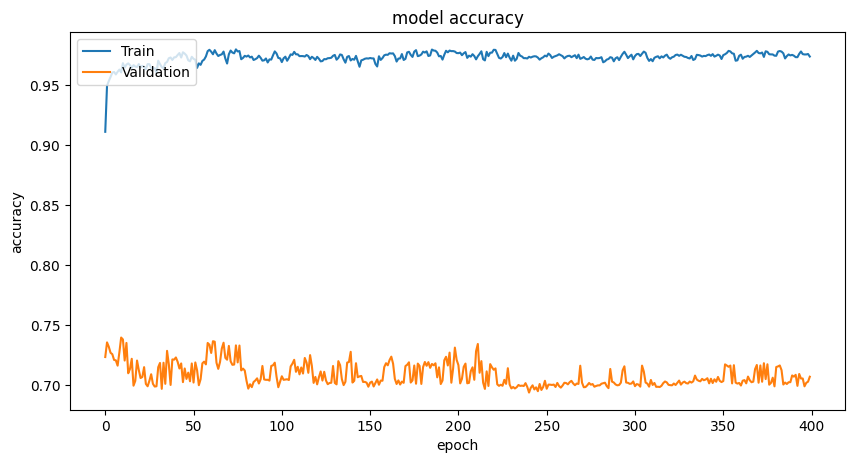

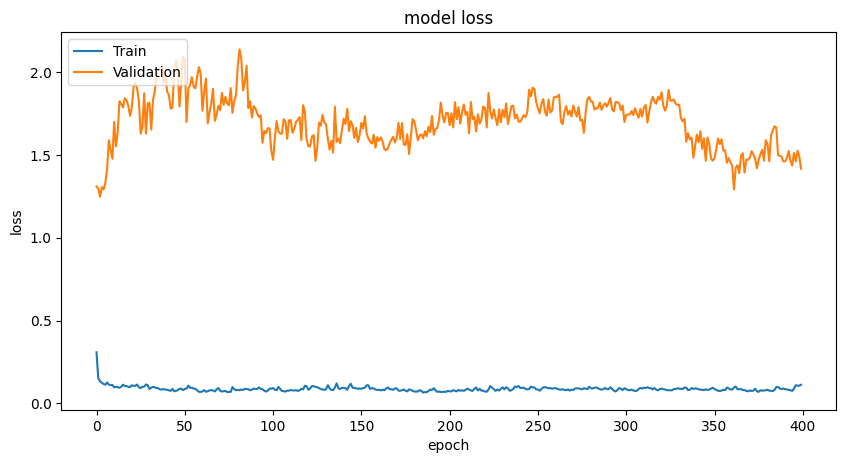

In [ ]:
import matplotlib.pyplot as plt
!rm -rf "./ckpt"
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint("./ckpt/checkpoint-{epoch:03d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('training_set_iranalysis.csv',separator=',', append=False)
print(model.summary())
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=400, callbacks=[checkpointer,csv_logger], validation_data=(X_test, y_test))

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from keras import models
import os

checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
latest_checkpoint = max(checkpoints, key=os.path.getctime)
model = models.load_model(latest_checkpoint)

loss, accuracy = model.evaluate(X_test, y_test)   
print('loss: ' + str(loss), 'accuracy:' + str(accuracy))


705/705 [==============================] - 2s 2ms/step - loss: 1.4778 - accuracy: 0.7398
loss: 1.4778062105178833 accuracy:0.7397977113723755


In [ ]:
y_pred = model.predict(X_test)
y_pred

705/705 [==============================] - 2s 2ms/step


array([[1.55900503e-04, 9.95963693e-01, 3.84507328e-03, 3.38336758e-05,
        1.41932503e-06],
       [1.88198045e-03, 4.83326823e-01, 5.13470829e-01, 1.23031368e-03,
        9.00341183e-05],
       [6.22472823e-01, 2.82993853e-01, 2.22286228e-02, 6.76946193e-02,
        4.60999925e-03],
       ...,
       [2.86024660e-01, 6.83559656e-01, 6.38632849e-03, 2.18565781e-02,
        2.17259745e-03],
       [9.98178542e-01, 1.25167264e-06, 1.79124391e-03, 2.70194651e-05,
        1.91658728e-06],
       [1.50564641e-01, 6.55095696e-01, 1.94107473e-01, 1.24324084e-04,
        1.07919484e-04]], dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[9442,   67,  200,    2,    0],
       [1430, 5791,  239,    0,    0],
       [ 698,  277, 1445,    1,    0],
       [2669,    1,  215,    0,    0],
       [  67,    0,    0,    0,    0]])

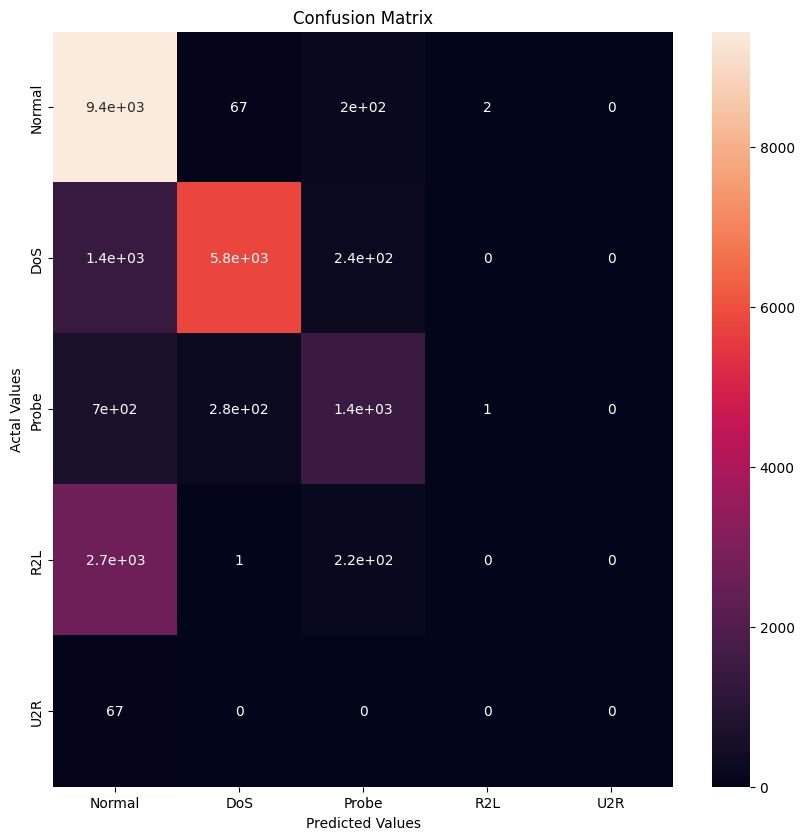

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_df = pd.DataFrame(cm,
                     index = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], 
                     columns = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R'])
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<ipython-input-28-23fa29999149>:24: RuntimeWarning: invalid value encountered in double_scalars
  list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])
<ipython-input-28-23fa29999149>:18: RuntimeWarning: invalid value encountered in long_scalars
  list_label[c]['PPV'] = tp/(tp+fp)


        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.972299  0.772312  0.660003  0.967346  0.027701  0.379023  0.339997   

        FOR  F1_score  
0  0.032654  0.786276  
        TPR       ACC       PPV       NPV       FNR       FPR       FDR  \
0  0.776273  0.910664  0.943774  0.898281  0.223727  0.022872  0.056226   

        FOR  F1_score  
0  0.101719  0.851868  
        TPR       ACC       PPV       NPV       FNR     FPR       FDR  \
0  0.596861  0.927697  0.688423  0.952262  0.403139  0.0325  0.311577   

        FOR  F1_score  
0  0.047738  0.639381  
   TPR       ACC  PPV       NPV  FNR       FPR  FDR       FOR  F1_score
0  0.0  0.871895  0.0  0.872011  1.0  0.000153  1.0  0.127989       NaN
   TPR       ACC  PPV       NPV  FNR  FPR  FDR       FOR  F1_score
0  0.0  0.997028  NaN  0.997028  1.0  0.0  NaN  0.002972       NaN


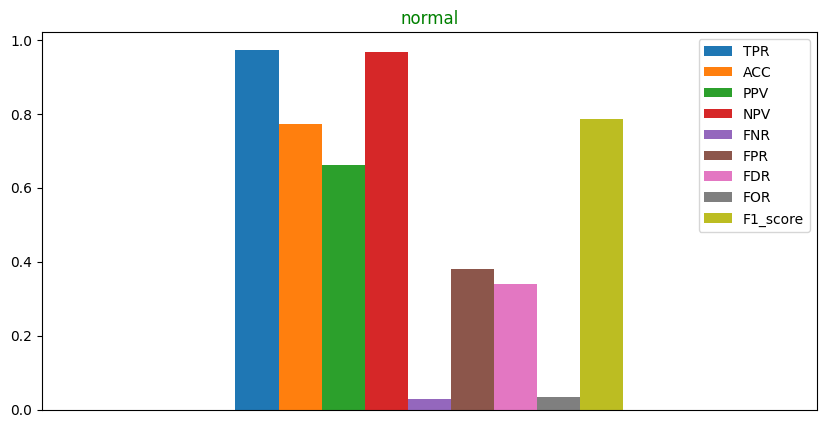

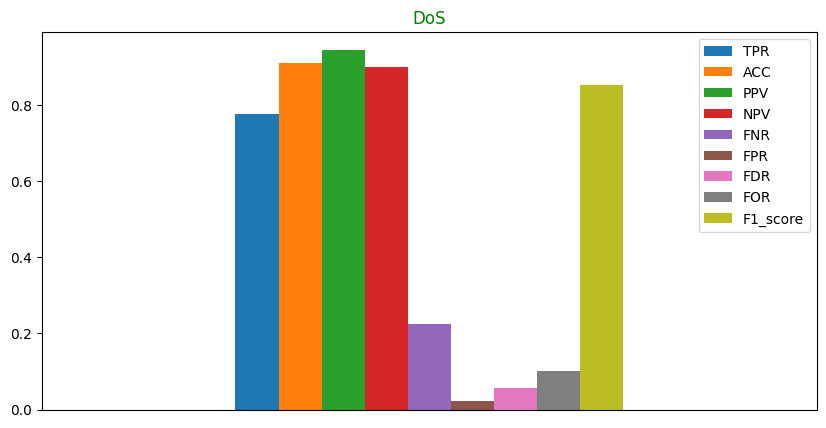

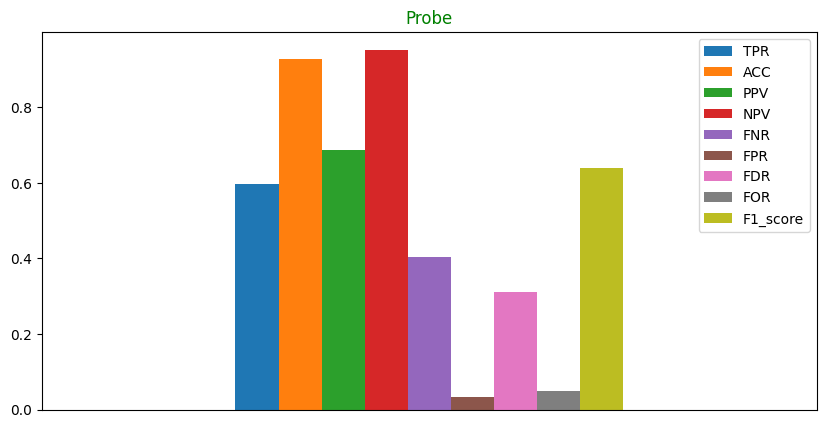

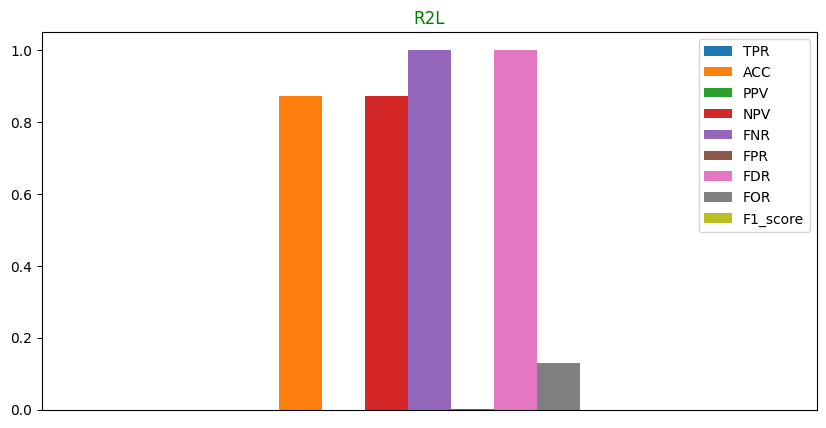

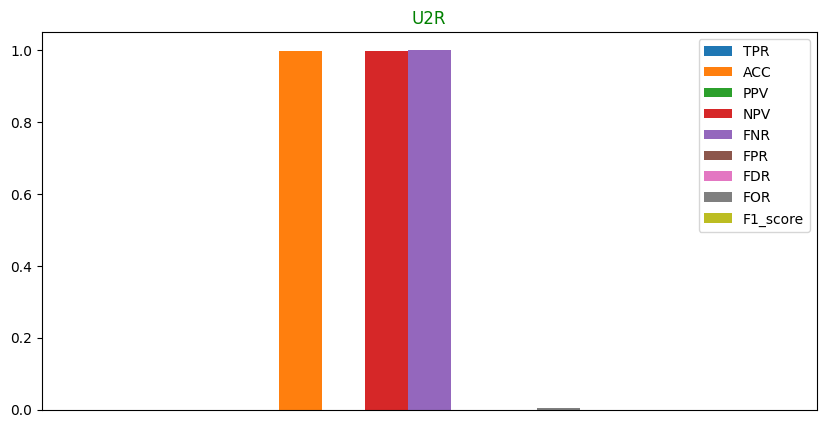

In [ ]:
normal = {}
DoS = {}
Probe = {}
R2L = {}
U2R = {}

list_label = [normal, DoS, Probe, R2L, U2R]
sum_matrix = sum(sum(cm))
for c in range(len(list_label)):
    tp = cm[c,c]
    fp = sum(cm[:,c]) - cm[c,c]
    fn = sum(cm[c,:]) - cm[c,c]
    # tn = sum(np.delete(sum(cm)-cm[c,:],c))
    tn = sum_matrix - tp - fp - fn
    list_label[c]['TPR'] = tp/(tp+fn)
    # recall = tp/(tp+fn)
    list_label[c]['ACC'] = (tp+tn)/(tp+fp+fn+tn)
    list_label[c]['PPV'] = tp/(tp+fp)
    list_label[c]['NPV'] = tn/(tn+fn)
    list_label[c]['FNR'] = 1 - list_label[c]['TPR']
    list_label[c]['FPR'] = fp/(fp+tn)
    list_label[c]['FDR'] = 1 - list_label[c]['PPV']
    list_label[c]['FOR'] = 1 - list_label[c]['NPV']
    list_label[c]['F1_score'] = (2*list_label[c]['PPV']*list_label[c]['TPR'])/(list_label[c]['PPV'] + list_label[c]['TPR'])
list_tt = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
for c in range(len(list_label)):

  normal = [list_label[c]]
  df = pd.DataFrame(normal)
  print(df)
  df.plot(kind='bar')
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.title(label=list_tt[c], color="green")
  plt.xlabel('') 
  plt.xticks([])
  plt.figure(1)
  plt.plot()